In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Import necessary libraries
import nltk
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
# Download necessary NLTK package
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [28]:
#Initialize the sentenceTransformer model to generate sentence embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

In [29]:
# Function to read CSV data and combine 'Title' and 'Abstract' columns into one text field
def preprocess_dataframe(csv_path):
    df = pd.read_csv(csv_path, encoding='ISO-8859-1')
    df['Combined_Text'] = df['Title'].fillna('') + " " + df['Abstract'].fillna('')
    return df

In [30]:
# Function to calculate relevance of text based on similarity to predefined target sentences
def calculate_relevance(df, target_sentences, column_name, similarity_threshold):
    # Encode target sentences into embeddings
    target_embeddings = model.encode(target_sentences, convert_to_tensor=True)

    relevance_scores = []
    count = 0

    # Iterate through each row in the dataframe
    for idx, row in df.iterrows():
        combined_text = row['Combined_Text']
        max_similarity = 0
        sentences = nltk.sent_tokenize(combined_text)

        # Encode and calculate similarities
        sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
        # Compute cosine similarity between text and target sentences
        similarities = util.pytorch_cos_sim(sentence_embeddings, target_embeddings)
        max_similarity = similarities.max().item()

        # Mark as relevant if similarity is above the threshold
        if max_similarity >= similarity_threshold:
            count += 1
            relevance_scores.append(1)
        else:
            relevance_scores.append(0)

    # Add the relevance results to the dataframe
    df[column_name] = relevance_scores

    print(f"{column_name}: {count} relevant rows identified (from {len(df)} filtered rows).")
    return df

In [31]:
# Function to evaluate predictions using ground truth labels
def evaluate_predictions(df, ground_truth_path, prediction_column):
    # Load ground truth labels
    ground_truth = pd.read_csv(ground_truth_path, encoding="ISO-8859-1")['Is_infectious'].to_numpy()
    print(len(ground_truth))

    # Extract predicted labels from the dataframe
    predicted = df[prediction_column].to_numpy()

    # Compute accuracy
    correct_predictions = np.sum(ground_truth == predicted)
    accuracy = correct_predictions / len(ground_truth)

    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Compute and display the confusion matrix
    cm = confusion_matrix(ground_truth, predicted)
    print("Confusion Matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")

In [32]:
#Define all the paramaters for first layer of embedding
SIMILARITY_THRESHOLD_GENERAL = 0.39
MEDICAL_CSV = '/content/drive/MyDrive/bioxriv/aggregated_deduplicated_bioxriv.csv'
UPDATED_MEDICAL_CSV = '/content/drive/MyDrive/bioxriv/OutputOfEmbedding1.csv'
GROUND_TRUTH_GENERAL = '/content/drive/MyDrive/bioxriv/aggregated_deduplicated_bioxriv_groundtruth.csv'

In [33]:
# Define medical-related keywords for relevance matching
target_sentences_general = [
    "Amebiasis", "Anthrax", "Arboviral Diseases", "Babesiosis", "Botulism",
    "Brucellosis", "COVID-19", "Campylobacteriosis", "Cholera",
    "Clostridium Perfringens", "Ebola", "Glanders", "Melioidosis",
    "Plague", "Ricin Poisoning", "Trichinosis", "Cryptosporidiosis",
    "Crypto", "Cyclosporiasis", "Dengue", "Diphtheria", "Ehrlichiosis",
    "Anaplasmosis", "Escherichia coli, Shiga toxin-producing", "Flu",
    "Giardiasis", "HIV", "AIDS", "Haemophilus influenza",  "Hansen's Disease",
    "Leprosy", "Hantavirus", "Hepatitis", "Hepatitis A", "Hepatitis B",
    "Hepatitis C", "Human Papillomavirus", "Influenza", "Legionellosis",
    "Leptospirosis", "Listeriosis", "Lyme Disease", "Malaria", "Measles",
    "Meningitis", "Meningococcal Disease", "Mumps", "Norovirus", "Pertussis",
    "Whooping Cough", "Pneumococcal Disease", "Poliomyelitis",
    "Psittacosis", "Q Fever", "Rabies", "Respiratory Syncytial Virus",
    "Rubella", "SARS-CoV-2", "Salmonellosis", "Shigellosis",
    "Shingles", "Smallpox", "Syphilis", "Tetanus", "Toxoplasmosis",
    "Tuberculosis", "Tularemia", "Typhoid", "Varicella", "Chickenpox",
    "Vibrio Infections", "West Nile Virus", "Yellow Fever", "Zika Virus",
    "Infectious Diseases", "Trichonosis Infection",  "Salmonellosis gastroenteritis",
    "Salmonella", "Shigellosis gastroenteritis", "Shigella", "Vibrio cholerae",
    "Vibriosis", "Vibrio", "Yersenia", "Yersinia", "Ciguatera", "Harmful Algae Blooms",
    "Paralytic Shellfish Poisoning", "Scombroid", "Staphylococcal Food Poisoning",
    "Enterotoxin - B Poisoning", "Epsilon Toxin", "Ebola Hemorrhagic Fever", "Plague",
    "Bubonic", "Septicemic", "Pneumonic", "Viral Hemorrhagic Fever", "Lassa",
    "Marburg", "Avian Influenza", "Non-Polio", "Enterovirus D68", "EV-D68",
    "Middle East Respiratory Syndrome Coronavirus", "MERS-CoV",
    "H-flu", "Legionnaires Disease", "Bacterial", "Parrot Fever",
    "Streptococcal Disease", "HIV", "AIDS", "Pediculosis", "Mycobacteriosis",
    "Alpha-gal Syndrome", "Powassan", "Rickettsiosis",
    "Rocky Mountain Spotted Fever", "Herpes Zoster", "zoster VZV",
    "Measles", "Mpox", "German Measles", "Tetanus Infection",
    "Lock Jaw", "Novel or emerging respiratory viruses", "Animal bites",
    "Chikungunya", "Eastern Equine Encephalitis", "Encephalitis Arboviral",
    "parainfectious", "Hantavirus Pulmonary Syndrome", "Monkeypox"
]


Is_infectious: 445 relevant rows identified (from 3294 filtered rows).
3294
Accuracy: 89.22%
Confusion Matrix:
[[2843  349]
 [   6   96]]


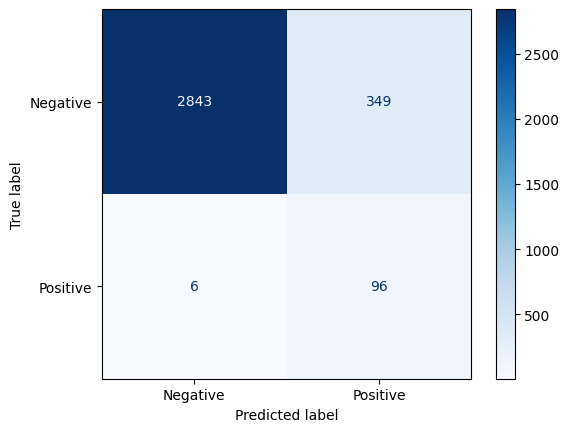

In [34]:
# Load and process the medical dataset
df = preprocess_dataframe(MEDICAL_CSV)

# Perform first-level filtering based on infectious diseases
df = calculate_relevance(df, target_sentences_general, 'Is_infectious', SIMILARITY_THRESHOLD_GENERAL)

# Save the filtered data to a new CSV file
df.to_csv(UPDATED_MEDICAL_CSV, index=False)

# Evaluate the performance of the first filtering step
evaluate_predictions(df, GROUND_TRUTH_GENERAL, 'Is_infectious')


In [44]:
#Define all the paramaters for second layer of embedding
SIMILARITY_THRESHOLD_DL = 0.40
UPDATED_MEDICAL_DL_CSV = '/content/drive/MyDrive/bioxriv/Input_to_embedding2.csv'
DL_OUTPUT_CSV = '/content/drive/MyDrive/bioxriv/OutputOfEmbedding2.csv'
GROUND_TRUTH_DL = '/content/drive/MyDrive/bioxriv/Groundtruth_for_embedding2.csv'

In [45]:
deep_learning_embedding2 = [
    "Deep learning", "Neural networks", "Multilayer perceptron", "Graph Convolutional Networks",
    "Convolutional neural network", "CNN", "RNN", "Recurrent neural network", "Long short-term memory",
    "Autoencoder", "Deep belief network", "Generative adversarial network", "Deep Q-network",
    "Backpropagation", "Gradient descent", "Fine-tuning",
    "Hyperparameter tuning", "Model evaluation", "Fully connected feedforward networks",
    "Data augmentation", "Feature extraction", "Stacked LSTMs", "Sequence modeling",
    "Transformer model", "BERT", "GPT", "XLNet",
    "ALBERT", "deep neural network", "artificial neural network", "feedforward neural network",
    "neural net algorithm", "graph neural network", "graph embedding", "graph representation learning",
    "node classification", "link prediction", "graph convolutional network",
    "message passing neural network", "graph attention network", "graph-based learning",
    "transformer", "self-attention", "encoder", "decoder", "encoder-decoder",
    "transformer architecture", "attention-based neural network", "transformer network",
    "sequence-to-sequence", "retrieval augmented generation", "RAG", "multimodal model",
    "multimodal neural network", "multimodal transformer", "multi-modal language model",
    "multi-modal large language model", "multimodal learning", "vision transformer",
    "diffusion model", "generative diffusion model", "diffusion-based generative model",
    "continuous diffusion model", "fusion model", "vision-language model",
    "visual question answering", "visual grounding", "text-to-image generation",
    "image-text alignment", "generative artificial intelligence", "generative AI",
    "generative deep learning", "generative models", "large language model", "LLM",
    "language model", "transformer-based model", "pretrained language model",
    "foundation model", "state-of-the-art language model", "finetuned models", "finetuning",
    "vision model", "image processing", "vision algorithm",
    "computer graphics and vision", "object recognition", "object detection",
    "image recognition", "image segmentation", "image captioning",
    "image classification", "visual recognition", "image synthesis",
    "scene understanding",     "natural language processing", "text mining", "NLP", "computational linguistics",
    "language processing", "text analytics", "textual data analysis", "text data analysis",
    "text analysis", "text classification", "text understanding", "text generation",
    "speech and language technology", "language modeling", "language representation learning",
    "word embedding", "vector embedding", "computational semantics",
    "Computer vision involves image recognition and object detection.",
    "Image processing and neural networks are integral to computer vision.",
]

Is_infectious: 260 relevant rows identified (from 445 filtered rows).
445
Accuracy: 43.82%
Confusion Matrix:
[[142 207]
 [ 43  53]]


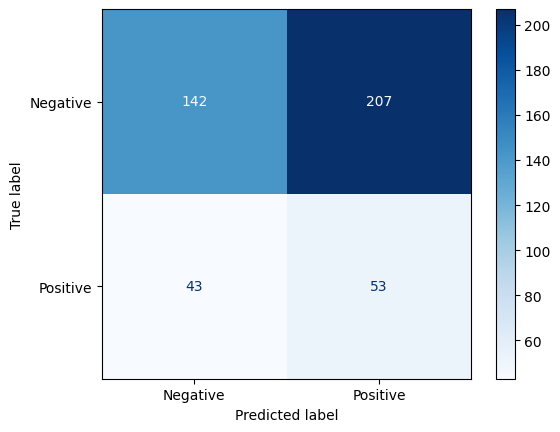

In [46]:
# Load and process the dataset after the first embedding step
df = preprocess_dataframe(UPDATED_MEDICAL_DL_CSV)

# Perform second-level filtering based on deep learning topics
df = calculate_relevance(df, deep_learning_embedding2, 'Is_infectious', 0.42)

# Save the deep learning relevance results
df.to_csv('/content/drive/MyDrive/medrxiv/OutputOfEmbedding2.csv', index=False)

# Evaluate the performance of the second filtering step
evaluate_predictions(df, GROUND_TRUTH_DL, 'Is_infectious')